In [1]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display


In [2]:
#%pip install matplotlib-venn

In [3]:
DATA_DIR = '.'

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}
name = "microbiology_events_codes_3"


In [4]:
df = pd.read_csv(f"{DATA_DIR}/{DATASETS[name]}", index_col=False)

df.columns

Index(['subject_id', 'hadm_id', 'chartdate', 'charttime', 'spec_type_desc',
       'test_name', 'org_name', 'ab_name', 'dilution_text',
       'dilution_comparison', 'dilution_value', 'interpretation',
       'technician_id', 'qc_flag'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           15587 non-null  int64  
 1   hadm_id              15587 non-null  float64
 2   chartdate            15587 non-null  object 
 3   charttime            15587 non-null  object 
 4   spec_type_desc       15587 non-null  object 
 5   test_name            15587 non-null  object 
 6   org_name             5391 non-null   object 
 7   ab_name              4820 non-null   object 
 8   dilution_text        4713 non-null   object 
 9   dilution_comparison  4711 non-null   object 
 10  dilution_value       4711 non-null   float64
 11  interpretation       4820 non-null   object 
 12  technician_id        15587 non-null  object 
 13  qc_flag              15587 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.7+ MB


In [99]:
df[['subject_id','hadm_id']].duplicated().any()

np.True_

# INspections

## A

In [7]:
df.head(10)

subject_id     hadm_id            chartdate            charttime  \
0    10000980  26913865.0  2189-06-27 00:00:00  2189-06-27 10:52:00   
1    10002155  23822395.0  2129-08-04 00:00:00  2129-08-04 17:04:00   
2    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 15:54:00   
3    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   
4    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   
5    10002155  23822395.0  2129-08-07 00:00:00  2129-08-07 12:07:00   
6    10002155  23822395.0  2129-08-07 00:00:00  2129-08-07 12:07:00   
7    10002155  23822395.0  2129-08-08 00:00:00  2129-08-08 12:22:00   
8    10002155  23822395.0  2129-08-09 00:00:00  2129-08-09 20:03:00   
9    10002155  23822395.0  2129-08-09 00:00:00  2129-08-09 20:03:00   

  spec_type_desc                               test_name org_name ab_name  \
0    MRSA SCREEN                             MRSA SCREEN      NaN     NaN   
1    MRSA SCREEN                             MRSA SCREEN      NaN     NaN   
2          URINE             Legionella Urinary Antigen       NaN     NaN   
3         SPUTUM                              GRAM STAIN      NaN     NaN   
4         SPUTUM                     RESPIRATORY CULTURE      NaN     NaN   
5         SPUTUM                         ACID FAST SMEAR      NaN     NaN   
6         SPUTUM                       ACID FAST CULTURE      NaN     NaN   
7          STOOL  CLOSTRIDIUM DIFFICILE TOXIN A & B TEST      NaN     NaN   
8         SPUTUM                              GRAM STAIN      NaN     NaN   
9         SPUTUM                     RESPIRATORY CULTURE      NaN     NaN   

  dilution_text dilution_comparison  dilution_value interpretation  \
0           NaN                 NaN             NaN            NaN   
1           NaN                 NaN             NaN            NaN   
2           NaN                 NaN             NaN            NaN   
3           NaN                 NaN             NaN            NaN   
4           NaN                 NaN             NaN            NaN   
5           NaN                 NaN             NaN            NaN   
6           NaN                 NaN             NaN            NaN   
7           NaN                 NaN             NaN            NaN   
8           NaN                 NaN             NaN            NaN   
9           NaN                 NaN             NaN            NaN   

  technician_id  qc_flag  
0      TECH_063    QC_OK  
1      TECH_095    QC_OK  
2      TECH_083    QC_OK  
3      TECH_095    QC_OK  
4      TECH_077    QC_OK  
5      TECH_068  QC_WARN  
6      TECH_084    QC_OK  
7      TECH_013    QC_OK  
8      TECH_033    QC_OK  
9      TECH_023  QC_WARN

In [9]:
df.tail(10)

subject_id     hadm_id            chartdate            charttime  \
15577    19997660  20374585.0  2175-10-12 00:00:00  2175-10-12 05:45:00   
15578    19997661  25968240.0  2172-03-15 00:00:00  2172-03-15 15:30:00   
15579    19997662  29338106.0  2182-08-22 00:00:00  2182-08-22 09:09:00   
15580    19997663  20511836.0  2158-06-06 00:00:00  2158-06-06 19:30:00   
15581    19997664  25289714.0  2186-01-02 00:00:00  2186-01-02 03:40:00   
15582    19997665  26052266.0  2173-11-09 00:00:00  2173-11-09 18:09:00   
15583    19997666  24256422.0  2168-08-03 00:00:00  2168-08-03 22:00:00   
15584    19997667  20372003.0  2144-09-21 00:00:00  2144-09-21 20:14:00   
15585    19997668  20329436.0  2129-08-12 00:00:00  2129-08-12 15:56:00   
15586    19997669  28219199.0  2160-07-03 00:00:00  2160-07-03 15:39:00   

          spec_type_desc                    test_name                org_name  \
15577      BLOOD CULTURE    Aerobic Bottle Gram Stain                     NaN   
15578        FLUID,OTHER               FUNGAL CULTURE                     NaN   
15579              URINE  Legionella Urinary Antigen                      NaN   
15580              URINE                URINE CULTURE        ESCHERICHIA COLI   
15581        MRSA SCREEN                  MRSA SCREEN                     NaN   
15582  Staph aureus swab          Staph aureus Screen                     NaN   
15583      BLOOD CULTURE       Blood Culture, Routine                     NaN   
15584              URINE                URINE CULTURE  PSEUDOMONAS AERUGINOSA   
15585    CATHETER TIP-IV                WOUND CULTURE                     NaN   
15586              URINE                URINE CULTURE   KLEBSIELLA PNEUMONIAE   

                  ab_name dilution_text dilution_comparison  dilution_value  \
15577                 NaN           NaN                 NaN             NaN   
15578                 NaN           NaN                 NaN             NaN   
15579                 NaN           NaN                 NaN             NaN   
15580          GENTAMICIN           <=1          <=                     1.0   
15581                 NaN           NaN                 NaN             NaN   
15582                 NaN           NaN                 NaN             NaN   
15583                 NaN           NaN                 NaN             NaN   
15584           MEROPENEM             8          =                      8.0   
15585                 NaN           NaN                 NaN             NaN   
15586  TRIMETHOPRIM/SULFA           <=1          <=                     1.0   

      interpretation technician_id  qc_flag  
15577            NaN      TECH_102    QC_OK  
15578            NaN      TECH_029    QC_OK  
15579            NaN      TECH_082    QC_OK  
15580              S      TECH_114    QC_OK  
15581            NaN      TECH_049    QC_OK  
15582            NaN      TECH_051    QC_OK  
15583            NaN      TECH_086    QC_OK  
15584              I      TECH_115  QC_FAIL  
15585            NaN      TECH_061    QC_OK  
15586              S      TECH_083  QC_WARN

## B

In [24]:
df["qc_flag"].value_counts(dropna=False) 

qc_flag
QC_OK      13235
QC_WARN     1572
QC_FAIL      779
Name: count, dtype: int64

S = Sensitive / Susceptible
The organism is inhibited by standard drug levels → drug is expected to work.

R = Resistant
The organism is not inhibited even at high drug concentrations → drug will not work.

I = Intermediate (older meaning) / I = Increased exposure (new CLSI meaning)

Historically: Result is uncertain; success depends on achieving high drug levels.

Modern definitions: Drug can work if exposure is increased (higher dose, longer infusion, high concentrations at infection site).

In [22]:
df["interpretation"].value_counts(dropna=False) 

interpretation
NaN    10766
S       3807
R        856
I        157
Name: count, dtype: int64

In [23]:
df["dilution_comparison"].value_counts(dropna=False) 

dilution_comparison
NaN           10875
<=             3233
=               782
=>              696
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           15587 non-null  int64  
 1   hadm_id              15587 non-null  float64
 2   chartdate            15587 non-null  object 
 3   charttime            15587 non-null  object 
 4   spec_type_desc       15587 non-null  object 
 5   test_name            15587 non-null  object 
 6   org_name             5391 non-null   object 
 7   ab_name              4820 non-null   object 
 8   dilution_text        4713 non-null   object 
 9   dilution_comparison  4711 non-null   object 
 10  dilution_value       4711 non-null   float64
 11  interpretation       4820 non-null   object 
 12  technician_id        15587 non-null  object 
 13  qc_flag              15587 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.7+ MB


==> spec_type_desc == fluid from df2?

# Data Understanding and Preprocessing, cleaning ofdf3 micro

In [100]:
df.duplicated().sum()

np.int64(1)

In [101]:
#show duplicated rows
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head(20)

subject_id     hadm_id            chartdate            charttime  \
2454    11823798  23491105.0  2186-07-16 00:00:00  2186-07-16 00:25:00   
2455    11823798  23491105.0  2186-07-16 00:00:00  2186-07-16 00:25:00   

     spec_type_desc               test_name org_name ab_name dilution_text  \
2454  BLOOD CULTURE  Blood Culture, Routine      NaN     NaN           NaN   
2455  BLOOD CULTURE  Blood Culture, Routine      NaN     NaN           NaN   

     dilution_comparison  dilution_value interpretation technician_id qc_flag  
2454                 NaN             NaN            NaN      TECH_120   QC_OK  
2455                 NaN             NaN            NaN      TECH_120   QC_OK

In [102]:
df = df.drop_duplicates()

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15586 entries, 0 to 15586
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           15586 non-null  int64  
 1   hadm_id              15586 non-null  float64
 2   chartdate            15586 non-null  object 
 3   charttime            15586 non-null  object 
 4   spec_type_desc       15586 non-null  object 
 5   test_name            15586 non-null  object 
 6   org_name             5391 non-null   object 
 7   ab_name              4820 non-null   object 
 8   dilution_text        4713 non-null   object 
 9   dilution_comparison  4711 non-null   object 
 10  dilution_value       4711 non-null   float64
 11  interpretation       4820 non-null   object 
 12  technician_id        15586 non-null  object 
 13  qc_flag              15586 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.8+ MB


In [104]:
for col in df.columns:
    if col == 'charttime' or col == 'hadm_id' or col == 'subject_id' or col == 'chartdate':
        continue
    print(f"{col}: {df[col].value_counts().tail(30)}")

spec_type_desc: spec_type_desc
CATHETER TIP-IV                                             113
Blood (EBV)                                                 112
BRONCHOALVEOLAR LAVAGE                                      107
Rapid Respiratory Viral Screen & Culture                    102
Influenza A/B by DFA                                         86
Blood (CMV AB)                                               86
BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)                         53
Mini-BAL                                                     49
IMMUNOLOGY                                                   46
BRONCHIAL WASHINGS                                           39
PERITONEAL FLUID                                             36
ABSCESS                                                      34
DIALYSIS FLUID                                               34
JOINT FLUID                                                  31
Immunology (CMV)                                             27
Blood (To

No wrong nans found

## Check for wrong NaNs / non typical entries in each column

#### Find wrong NaNs

- valueuom: has '' , remove; Pos/Neg == +/-; U ??
- value has wrong entries inspect and extrat if possible to valuenum


### Handle Value wrong nans, then extract missing from value into new column valuenum_merged if possible

In [105]:
# # chec k only value column: show all unique non-numerical entries in 'value' column
# non_numerical_values = []
# for idx, value in df['value'].items():
#     if pd.isna(value):  # Skip NaN/None
#         continue
    
#     # Try to convert to float
#     try:
#         float(value)
#     except (ValueError, TypeError):
#         non_numerical_values.append({
#             'index': idx,
#             'value': value,
#             'type': type(value).__name__
#         })
# print(f"\n{'─'*80}")
# print(f"Column: 'value' | Non-numerical entries: {len(non_numerical_values)}")
# print(f"{'─'*80}")
# # Get unique non-numerical values
# unique_values = list(set([e['value'] for e in non_numerical_values]))
# print(f"Unique non-numerical values ({len(unique_values)}):")
# for val in sorted(unique_values):
#     count = sum(1 for e in non_numerical_values if e['value'] == val)
#     print(f"  • '{val}' — appears {count} times")   
    

FINDINGS

=> in col value, We want to convert '___' and 'NONE' 'ERROR' to np.nan!

=> then we create a new col value_extracted (float64) out of col value where:
- we can calculate as float complete / like 20/0 but only if there is anumber before and after the /! => complete
- we can take the middle point of complete ranges like '80-160'
- we can calculate a float value of comparisons with < > by sub/add 0.1 to the number, eg. '>1.050' => 1.150 or '<1' => 0.9
- the rest is to nuemic error coerce put to NaN.

=> then, we fill np.nan entries in col valuenum with values from valUe_extracted if they are not nan and tell me the amount of filled rows and show examples beffore and after

 ## Convert datetimes

In [106]:
cols = ['charttime', 'chartdate']  

for col in cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"{col}: parsed {df[col].notna().sum()} values, {df[col].isna().sum()} NaT")

display(df[[c for c in df.columns if c in cols]])

charttime: parsed 15586 values, 0 NaT
chartdate: parsed 15586 values, 0 NaT


chartdate           charttime
0     2189-06-27 2189-06-27 10:52:00
1     2129-08-04 2129-08-04 17:04:00
2     2129-08-05 2129-08-05 15:54:00
3     2129-08-05 2129-08-05 18:43:00
4     2129-08-05 2129-08-05 18:43:00
...          ...                 ...
15582 2173-11-09 2173-11-09 18:09:00
15583 2168-08-03 2168-08-03 22:00:00
15584 2144-09-21 2144-09-21 20:14:00
15585 2129-08-12 2129-08-12 15:56:00
15586 2160-07-03 2160-07-03 15:39:00

[15586 rows x 2 columns]

## inspect qc_flag == FAIL

In [107]:
# check qc_flag == 'FAIL' 
df["qc_flag"].value_counts()

qc_flag
QC_OK      13235
QC_WARN     1572
QC_FAIL      779
Name: count, dtype: int64

inspect fail dataset

In [108]:
df_test = df[df["qc_flag"] == 'QC_FAIL'].copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779 entries, 42 to 15584
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subject_id           779 non-null    int64         
 1   hadm_id              779 non-null    float64       
 2   chartdate            779 non-null    datetime64[ns]
 3   charttime            779 non-null    datetime64[ns]
 4   spec_type_desc       779 non-null    object        
 5   test_name            779 non-null    object        
 6   org_name             290 non-null    object        
 7   ab_name              259 non-null    object        
 8   dilution_text        255 non-null    object        
 9   dilution_comparison  255 non-null    object        
 10  dilution_value       255 non-null    float64       
 11  interpretation       259 non-null    object        
 12  technician_id        779 non-null    object        
 13  qc_flag              779 non-null    

2% fail, 8% warn.

IDEA: small percentage => set valuenum_merged to np.nan those rows bc qualtiy control failed

In [109]:
# Handle QC flags
qc_fail_mask = df['qc_flag'] == 'QC_FAIL'
qc_warn_mask = df['qc_flag'] == 'QC_WARN'

# Drop failed measurements from dilution_value       
before_non_null = df['dilution_value'].notna().sum()
df.loc[qc_fail_mask, 'dilution_value'] = np.nan
df.loc[qc_fail_mask, 'dilution_comparison'] = np.nan
df.loc[qc_fail_mask, 'dilution_text'] = np.nan
after_non_null = df['dilution_value'].notna().sum()

print(f"set {before_non_null - after_non_null:,} FAIL measurements from dilution_value to nan.")
print(f"Coverage drop: {(before_non_null - after_non_null) / len(df) * 100:.2f}%")

# Binary QC features for downstream aggregation/clustering
df['is_qc_fail'] = qc_fail_mask.astype(int)
df['is_qc_warn'] = qc_warn_mask.astype(int)
df['is_qc_ok'] = (~qc_fail_mask & ~qc_warn_mask).astype(int)

print(df[['qc_flag', 'is_qc_ok', 'is_qc_warn', 'is_qc_fail']].head())

set 255 FAIL measurements from dilution_value to nan.
Coverage drop: 1.64%
  qc_flag  is_qc_ok  is_qc_warn  is_qc_fail
0   QC_OK         1           0           0
1   QC_OK         1           0           0
2   QC_OK         1           0           0
3   QC_OK         1           0           0
4   QC_OK         1           0           0


## Check if dilution_text matches with diluation_value and dilution_comparison

In [110]:
# check if 
df_test = df[df["dilution_comparison"].isna()].copy()
df_test["dilution_text"].value_counts(dropna=False)

dilution_text
NaN     11128
>256        2
Name: count, dtype: int64

In [111]:
df_test[df["dilution_text"] == ">256"]

C:\Users\dgars\AppData\Local\Temp\ipykernel_17012\2108123711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df["dilution_text"] == ">256"]


subject_id     hadm_id  chartdate           charttime spec_type_desc  \
8607     15762152  21311947.0 2134-02-07 2134-02-07 22:30:00           SWAB   
13478    18991843  26003222.0 2146-05-01 2146-05-01 06:03:00           SWAB   

                                   test_name          org_name     ab_name  \
8607   R/O VANCOMYCIN RESISTANT ENTEROCOCCUS  ENTEROCOCCUS SP.  VANCOMYCIN   
13478  R/O VANCOMYCIN RESISTANT ENTEROCOCCUS  ENTEROCOCCUS SP.  VANCOMYCIN   

      dilution_text dilution_comparison  dilution_value interpretation  \
8607           >256                 NaN             NaN              R   
13478          >256                 NaN             NaN              R   

      technician_id qc_flag  is_qc_fail  is_qc_warn  is_qc_ok  
8607       TECH_062   QC_OK           0           0         1  
13478      TECH_117   QC_OK           0           0         1

fix those

In [112]:
df.loc[df["dilution_text"] == ">256", "dilution_comparison"] = ">"
df.loc[df["dilution_text"] == ">256", "dilution_value"] = 256.0

#### in genreal (same findings)

In [113]:
# in general:
print("="*80)
print("CHECK: dilution_text vs dilution_value + dilution_comparison")
print("="*80)

# Extract comparison operator and value from dilution_text
def parse_dilution_text(text):
    if pd.isna(text):
        return np.nan, np.nan
    text = str(text).strip()
    
    # Match patterns like ">256", "<=0.5", "=4", etc.
    match = re.match(r'^([<>=]+)?\s*(\d+\.?\d*)$', text)
    if match:
        comp = match.group(1) if match.group(1) else '='
        val = float(match.group(2))
        return comp, val
    return np.nan, np.nan

# Parse dilution_text
parsed = df['dilution_text'].apply(parse_dilution_text)
df['_parsed_comp'] = parsed.apply(lambda x: x[0])
df['_parsed_val'] = parsed.apply(lambda x: x[1])

# Compare with existing columns
df['_comp_match'] = df['_parsed_comp'] == df['dilution_comparison']
df['_val_match'] = df['_parsed_val'] == df['dilution_value']

# Summary
has_text = df['dilution_text'].notna()
print(f"\nRows with dilution_text: {has_text.sum():,}")

comp_match = (df['_comp_match'] == True).sum()
val_match = (df['_val_match'] == True).sum()
both_match = ((df['_comp_match'] == True) & (df['_val_match'] == True)).sum()

print(f"\nComparison matches: {comp_match:,}")
print(f"Value matches: {val_match:,}")
print(f"Both match: {both_match:,}")

# Show mismatches
mismatches = df[has_text & ((df['_comp_match'] == False) | (df['_val_match'] == False))]
print(f"\nMismatches: {len(mismatches):,}")

if len(mismatches) > 0:
    print("\nSample mismatches:")
    display(mismatches[['dilution_text', '_parsed_comp', '_parsed_val', 
                        'dilution_comparison', 'dilution_value']].head(20))

# Show rows where dilution_text exists but comparison/value is NaN
missing_parsed = df[has_text & (df['dilution_comparison'].isna() | df['dilution_value'].isna())]
print(f"\nRows with dilution_text but missing comparison/value: {len(missing_parsed):,}")
if len(missing_parsed) > 0:
    print("\nSample rows to potentially fill:")
    display(missing_parsed[['dilution_text', '_parsed_comp', '_parsed_val', 
                            'dilution_comparison', 'dilution_value']].head(20))

# Cleanup
df.drop(columns=['_parsed_comp', '_parsed_val', '_comp_match', '_val_match'], inplace=True)

CHECK: dilution_text vs dilution_value + dilution_comparison

Rows with dilution_text: 4,458

Comparison matches: 2
Value matches: 4,458
Both match: 2

Mismatches: 4,456

Sample mismatches:


dilution_text _parsed_comp  _parsed_val dilution_comparison  \
125             8            =         8.00          =            
126           <=1           <=         1.00          <=           
127          <=16           <=        16.00          <=           
128           <=1           <=         1.00          <=           
129           <=1           <=         1.00          <=           
130           <=1           <=         1.00          <=           
131           <=1           <=         1.00          <=           
132        <=0.25           <=         0.25          <=           
133             8            =         8.00          =            
134           <=1           <=         1.00          <=           
135        <=0.25           <=         0.25          <=           
157           =>8           =>         8.00          =>           
158           =>8           =>         8.00          =>           
159         <=0.5           <=         0.50          <=           
160             2            =         2.00          =            
161         <=0.5           <=         0.50          <=           
162             1            =         1.00          =            
163           =>4           =>         4.00          =>           
164           =>8           =>         8.00          =>           
165         <=0.5           <=         0.50          <=           

     dilution_value  
125            8.00  
126            1.00  
127           16.00  
128            1.00  
129            1.00  
130            1.00  
131            1.00  
132            0.25  
133            8.00  
134            1.00  
135            0.25  
157            8.00  
158            8.00  
159            0.50  
160            2.00  
161            0.50  
162            1.00  
163            4.00  
164            8.00  
165            0.50


Rows with dilution_text but missing comparison/value: 0


## Little intermed inspection 

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15586 entries, 0 to 15586
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subject_id           15586 non-null  int64         
 1   hadm_id              15586 non-null  float64       
 2   chartdate            15586 non-null  datetime64[ns]
 3   charttime            15586 non-null  datetime64[ns]
 4   spec_type_desc       15586 non-null  object        
 5   test_name            15586 non-null  object        
 6   org_name             5391 non-null   object        
 7   ab_name              4820 non-null   object        
 8   dilution_text        4458 non-null   object        
 9   dilution_comparison  4458 non-null   object        
 10  dilution_value       4458 non-null   float64       
 11  interpretation       4820 non-null   object        
 12  technician_id        15586 non-null  object        
 13  qc_flag              15586 non-null 

In [115]:
df['hadm_id'] = df['hadm_id'].astype('int64')

## Handle missing values

In [116]:
# print sum of all missing values per column
for col in df.columns:
    missing_count = df[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'org_name': 10195 missing values
Column 'ab_name': 10766 missing values
Column 'dilution_text': 11128 missing values
Column 'dilution_comparison': 11128 missing values
Column 'dilution_value': 11128 missing values
Column 'interpretation': 10766 missing values


In [117]:
#%pip install matplotlib-venn

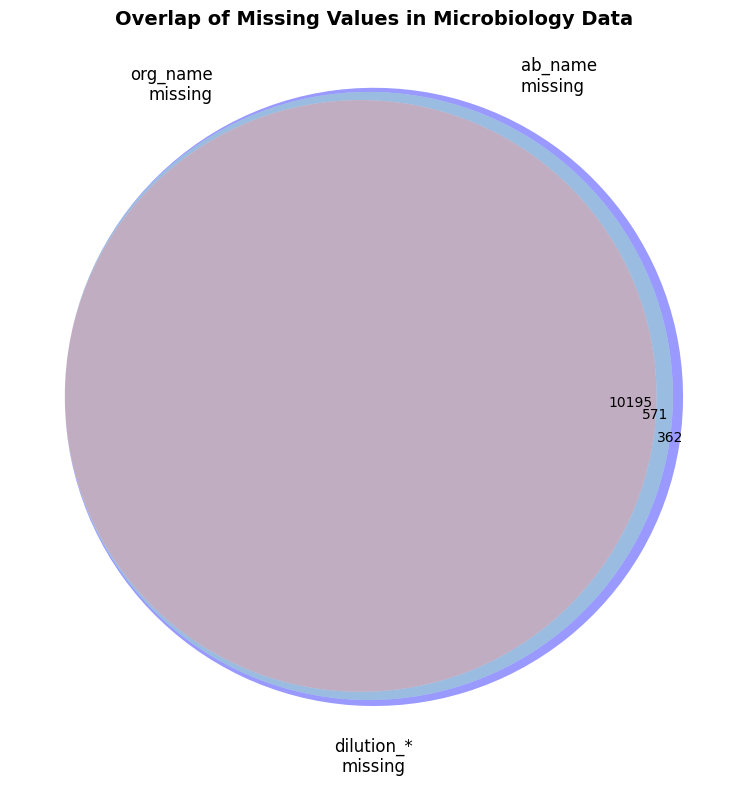

MISSING VALUES OVERLAP SUMMARY

Total rows: 15,586

Individual missing counts:
  org_name:    10,195
  ab_name:     10,766
  dilution_*:  11,128

Overlap breakdown:
  Only org_name missing:              0
  Only ab_name missing:               0
  Only dilution_* missing:            362
  org_name + ab_name:                 0
  org_name + dilution_*:              0
  ab_name + dilution_*:               571
  All three missing:                  10,195

Rows with ANY missing:              11,128
Rows with NO missing (complete):    4,458


In [118]:
# overlap of those missing vals (maybe venn diagramm actually? )
from matplotlib_venn import venn3

# Create missing value masks
missing_org = df['org_name'].isna()
missing_ab = df['ab_name'].isna()
missing_dilution = df['dilution_text'].isna()  # dilution_comparison, dilution_value have same pattern

# Calculate overlaps
only_org = (missing_org & ~missing_ab & ~missing_dilution).sum()
only_ab = (~missing_org & missing_ab & ~missing_dilution).sum()
only_dilution = (~missing_org & ~missing_ab & missing_dilution).sum()
org_ab = (missing_org & missing_ab & ~missing_dilution).sum()
org_dilution = (missing_org & ~missing_ab & missing_dilution).sum()
ab_dilution = (~missing_org & missing_ab & missing_dilution).sum()
all_three = (missing_org & missing_ab & missing_dilution).sum()

# Venn diagram
fig, ax = plt.subplots(figsize=(10, 8))
venn = venn3(
    subsets=(only_org, only_ab, org_ab, only_dilution, org_dilution, ab_dilution, all_three),
    set_labels=('org_name\nmissing', 'ab_name\nmissing', 'dilution_*\nmissing'),
    ax=ax
)
ax.set_title('Overlap of Missing Values in Microbiology Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('missing_values_venn.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary table
print("="*60)
print("MISSING VALUES OVERLAP SUMMARY")
print("="*60)
print(f"\nTotal rows: {len(df):,}")
print(f"\nIndividual missing counts:")
print(f"  org_name:    {missing_org.sum():,}")
print(f"  ab_name:     {missing_ab.sum():,}")
print(f"  dilution_*:  {missing_dilution.sum():,}")
print(f"\nOverlap breakdown:")
print(f"  Only org_name missing:              {only_org:,}")
print(f"  Only ab_name missing:               {only_ab:,}")
print(f"  Only dilution_* missing:            {only_dilution:,}")
print(f"  org_name + ab_name:                 {org_ab:,}")
print(f"  org_name + dilution_*:              {org_dilution:,}")
print(f"  ab_name + dilution_*:               {ab_dilution:,}")
print(f"  All three missing:                  {all_three:,}")
print(f"\nRows with ANY missing:              {(missing_org | missing_ab | missing_dilution).sum():,}")
print(f"Rows with NO missing (complete):    {(~missing_org & ~missing_ab & ~missing_dilution).sum():,}")

### Do correlation matrix

## Save

In [119]:
df.to_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_cleaned.csv')}", index=False)

In [120]:
# load already cleaned to skip first steps
#df = pd.read_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_cleaned.csv')}")

In [121]:
cols = ['charttime', 'chartdate']  

for col in cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"{col}: parsed {df[col].notna().sum()} values, {df[col].isna().sum()} NaT")

display(df[[c for c in df.columns if c in cols]])

charttime: parsed 15586 values, 0 NaT
chartdate: parsed 15586 values, 0 NaT


chartdate           charttime
0     2189-06-27 2189-06-27 10:52:00
1     2129-08-04 2129-08-04 17:04:00
2     2129-08-05 2129-08-05 15:54:00
3     2129-08-05 2129-08-05 18:43:00
4     2129-08-05 2129-08-05 18:43:00
...          ...                 ...
15582 2173-11-09 2173-11-09 18:09:00
15583 2168-08-03 2168-08-03 22:00:00
15584 2144-09-21 2144-09-21 20:14:00
15585 2129-08-12 2129-08-12 15:56:00
15586 2160-07-03 2160-07-03 15:39:00

[15586 rows x 2 columns]

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15586 entries, 0 to 15586
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subject_id           15586 non-null  int64         
 1   hadm_id              15586 non-null  int64         
 2   chartdate            15586 non-null  datetime64[ns]
 3   charttime            15586 non-null  datetime64[ns]
 4   spec_type_desc       15586 non-null  object        
 5   test_name            15586 non-null  object        
 6   org_name             5391 non-null   object        
 7   ab_name              4820 non-null   object        
 8   dilution_text        4458 non-null   object        
 9   dilution_comparison  4458 non-null   object        
 10  dilution_value       4458 non-null   float64       
 11  interpretation       4820 non-null   object        
 12  technician_id        15586 non-null  object        
 13  qc_flag              15586 non-null 

# Create features and slim version

In [123]:
df_slim = df.copy() 

In [124]:
df_slim.columns

Index(['subject_id', 'hadm_id', 'chartdate', 'charttime', 'spec_type_desc',
       'test_name', 'org_name', 'ab_name', 'dilution_text',
       'dilution_comparison', 'dilution_value', 'interpretation',
       'technician_id', 'qc_flag', 'is_qc_fail', 'is_qc_warn', 'is_qc_ok'],
      dtype='object')

In [125]:
df_slim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15586 entries, 0 to 15586
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subject_id           15586 non-null  int64         
 1   hadm_id              15586 non-null  int64         
 2   chartdate            15586 non-null  datetime64[ns]
 3   charttime            15586 non-null  datetime64[ns]
 4   spec_type_desc       15586 non-null  object        
 5   test_name            15586 non-null  object        
 6   org_name             5391 non-null   object        
 7   ab_name              4820 non-null   object        
 8   dilution_text        4458 non-null   object        
 9   dilution_comparison  4458 non-null   object        
 10  dilution_value       4458 non-null   float64       
 11  interpretation       4820 non-null   object        
 12  technician_id        15586 non-null  object        
 13  qc_flag              15586 non-null 

## features

In [129]:
df_micro = df_slim.copy()

gb = df_micro.groupby(['subject_id', 'hadm_id'])

In [130]:
def first_non_null(series):
    """Get first non-null value, or None if all null"""
    non_null = series.dropna()
    return non_null.iloc[0] if len(non_null) > 0 else None

In [131]:
# --- Core count ---
feat_total_micro = gb.size().rename('total_microbio_events')

# --- Diversity features ---
feat_spec_types = gb['spec_type_desc'].nunique().rename('unique_specimen_types')
feat_test_names = gb['test_name'].nunique().rename('unique_test_names')
feat_orgs = gb['org_name'].nunique().rename('unique_organisms')
feat_ab = gb['ab_name'].nunique().rename('unique_antibiotics')
feat_tech = gb['technician_id'].nunique().rename('unique_technicians')

# --- Susceptibility ---
feat_susc = gb['interpretation'].apply(lambda x: (x == 'S').sum()).rename('num_susceptible')
feat_res  = gb['interpretation'].apply(lambda x: (x == 'R').sum()).rename('num_resistant')
feat_int  = gb['interpretation'].apply(lambda x: (x == 'I').sum()).rename('num_intermediate')

feat_res_ratio = (feat_res / feat_total_micro).rename('resistant_ratio')

# --- QC flags ---
feat_qc_fail = gb['is_qc_fail'].sum().rename('micro_qc_fail')
feat_qc_warn = gb['is_qc_warn'].sum().rename('micro_qc_warn')
feat_qc_ok   = gb['is_qc_ok'].sum().rename('micro_qc_ok')

# --- Temporal ---
feat_time_span = (
    (gb['charttime'].max() - gb['charttime'].min()).dt.total_seconds() / 3600
).rename('micro_time_span_hours')

# --- Merge ---
micro_features = pd.concat([
    feat_total_micro,
    feat_spec_types,
    feat_test_names,
    feat_orgs,
    feat_ab,
    feat_tech,
    feat_susc,
    feat_res,
    feat_int,
    feat_res_ratio,
    feat_qc_fail,
    feat_qc_warn,
    feat_qc_ok,
    feat_time_span
], axis=1)

# presence flag
micro_features['has_micro'] = 1

micro_features = micro_features.reset_index()

In [132]:
micro_features.head()

subject_id   hadm_id  total_microbio_events  unique_specimen_types  \
0    10000980  26913865                      1                      1   
1    10002155  23822395                     12                      4   
2    10007058  22954658                      2                      2   
3    10013569  22891949                      1                      1   
4    10017531  20668418                      1                      1   

   unique_test_names  unique_organisms  unique_antibiotics  \
0                  1                 0                   0   
1                  7                 0                   0   
2                  2                 0                   0   
3                  1                 0                   0   
4                  1                 0                   0   

   unique_technicians  num_susceptible  num_resistant  num_intermediate  \
0                   1                0              0                 0   
1                  11                0              0                 0   
2                   2                0              0                 0   
3                   1                0              0                 0   
4                   1                0              0                 0   

   resistant_ratio  micro_qc_fail  micro_qc_warn  micro_qc_ok  \
0              0.0              0              0            1   
1              0.0              0              2           10   
2              0.0              0              0            2   
3              0.0              0              0            1   
4              0.0              0              0            1   

   micro_time_span_hours  has_micro  
0               0.000000          1  
1             215.966667          1  
2              28.650000          1  
3               0.000000          1  
4               0.000000          1

In [133]:
micro_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756 entries, 0 to 2755
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             2756 non-null   int64  
 1   hadm_id                2756 non-null   int64  
 2   total_microbio_events  2756 non-null   int64  
 3   unique_specimen_types  2756 non-null   int64  
 4   unique_test_names      2756 non-null   int64  
 5   unique_organisms       2756 non-null   int64  
 6   unique_antibiotics     2756 non-null   int64  
 7   unique_technicians     2756 non-null   int64  
 8   num_susceptible        2756 non-null   int64  
 9   num_resistant          2756 non-null   int64  
 10  num_intermediate       2756 non-null   int64  
 11  resistant_ratio        2756 non-null   float64
 12  micro_qc_fail          2756 non-null   int64  
 13  micro_qc_warn          2756 non-null   int64  
 14  micro_qc_ok            2756 non-null   int64  
 15  micr

In [134]:
micro_features.to_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_agg_features_large.csv')}", index=False)

reduced set

### Corr

CORRELATION MATRIX ANALYSIS

Numeric columns found: ['subject_id', 'hadm_id', 'total_microbio_events', 'unique_specimen_types', 'unique_test_names', 'unique_organisms', 'unique_antibiotics', 'unique_technicians', 'num_susceptible', 'num_resistant', 'num_intermediate', 'resistant_ratio', 'micro_qc_fail', 'micro_qc_warn', 'micro_qc_ok', 'micro_time_span_hours', 'has_micro']
Total numeric columns: 17

CORRELATION MATRIX
                       subject_id  hadm_id  total_microbio_events  \
subject_id                  1.000   -0.011                 -0.086   
hadm_id                    -0.011    1.000                 -0.001   
total_microbio_events      -0.086   -0.001                  1.000   
unique_specimen_types      -0.112   -0.003                  0.665   
unique_test_names          -0.099    0.005                  0.670   
unique_organisms           -0.010   -0.028                  0.665   
unique_antibiotics         -0.052   -0.007                  0.643   
unique_technicians         

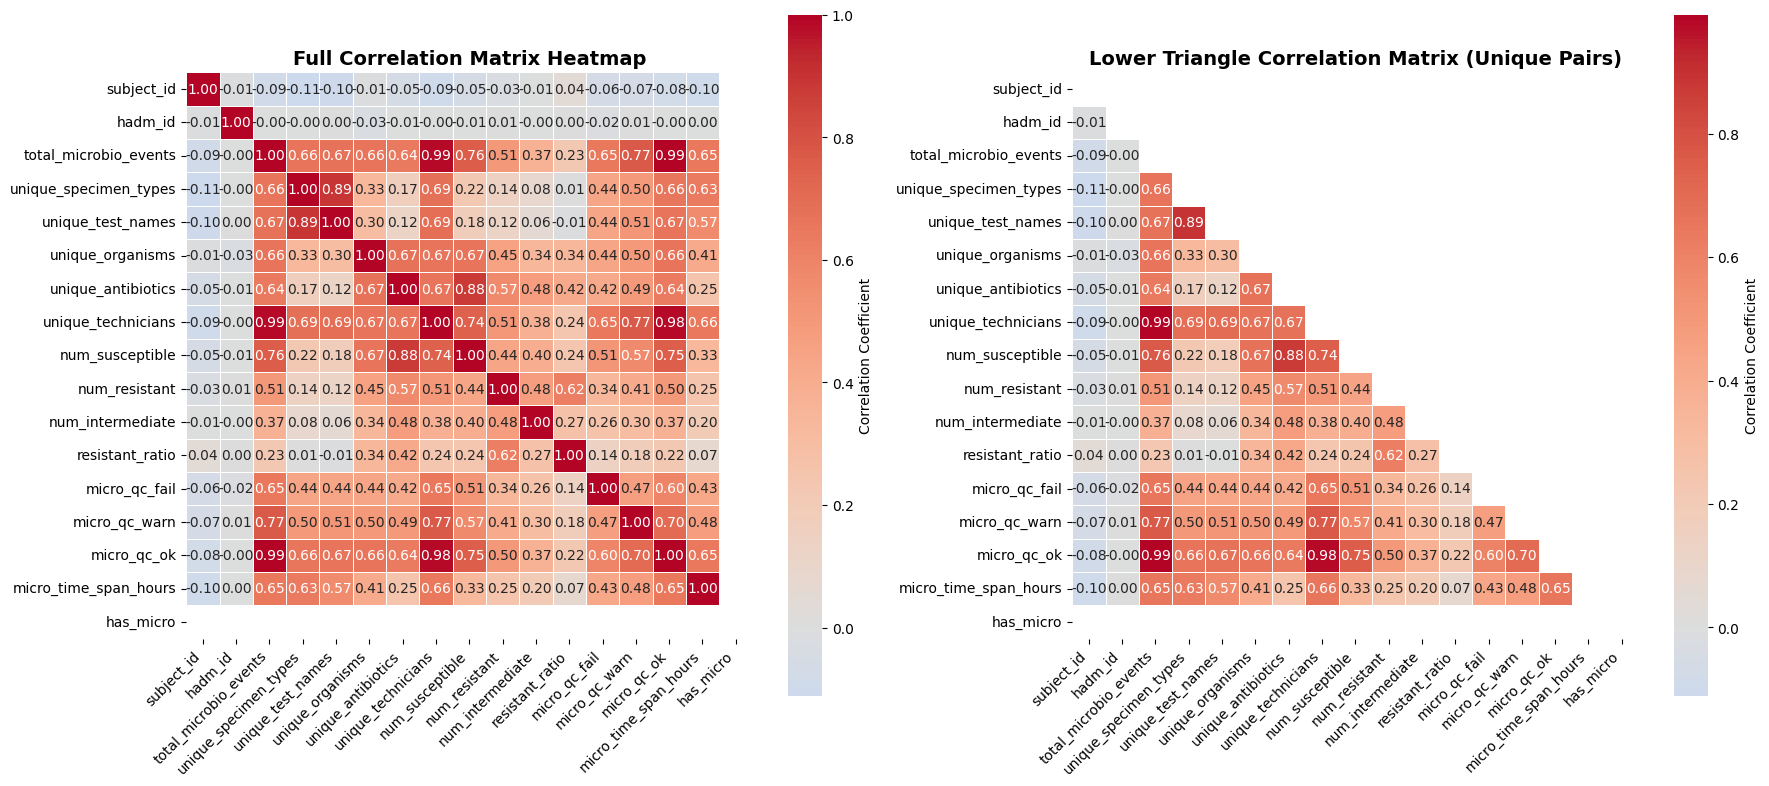


STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)

Found 11 strong correlations:

           Variable 1         Variable 2  Correlation        Strength
total_microbio_events        micro_qc_ok     0.993120 Strong Positive
total_microbio_events unique_technicians     0.990860 Strong Positive
   unique_technicians        micro_qc_ok     0.982787 Strong Positive
unique_specimen_types  unique_test_names     0.890931 Strong Positive
   unique_antibiotics    num_susceptible     0.875749 Strong Positive
total_microbio_events      micro_qc_warn     0.766980 Strong Positive
   unique_technicians      micro_qc_warn     0.765602 Strong Positive
total_microbio_events    num_susceptible     0.760190 Strong Positive
      num_susceptible        micro_qc_ok     0.754477 Strong Positive
   unique_technicians    num_susceptible     0.744262 Strong Positive
        micro_qc_warn        micro_qc_ok     0.701914 Strong Positive

MODERATE CORRELATIONS (0.3 < |r| ≤ 0.7)

Found 57 moderate correl

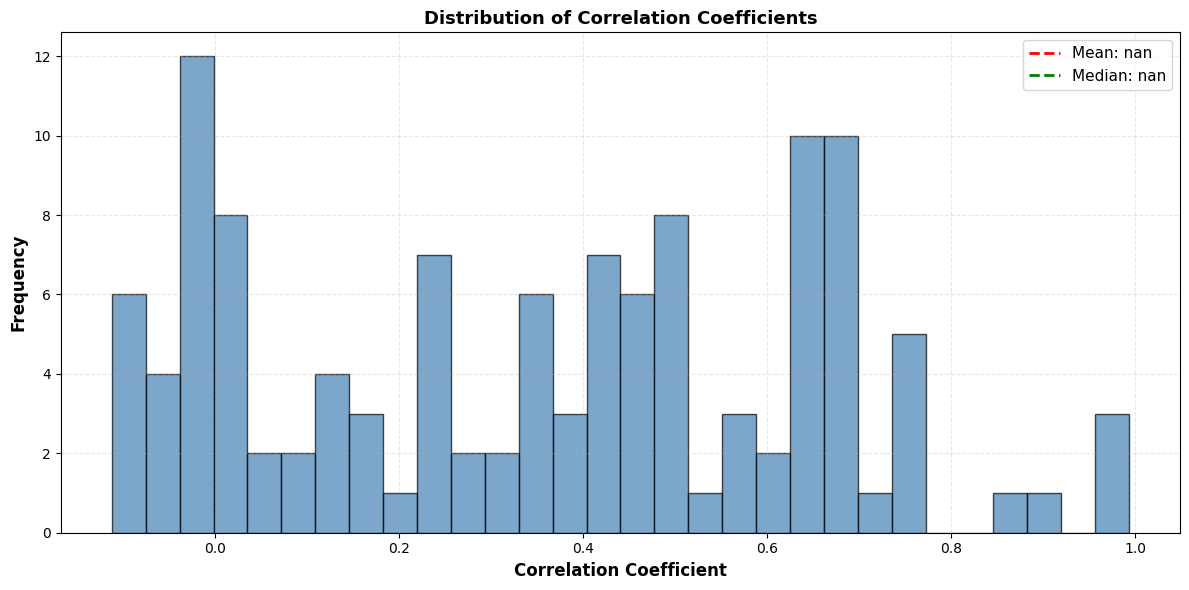

In [135]:
print("="*80)
print("CORRELATION MATRIX ANALYSIS")
print("="*80)

# Select numeric columns only
numeric_cols = micro_features.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns found: {numeric_cols}")
print(f"Total numeric columns: {len(numeric_cols)}\n")

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    correlation_matrix = micro_features[numeric_cols].corr()
    
    print("="*80)
    print("CORRELATION MATRIX")
    print("="*80)
    print(correlation_matrix.round(3))
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Full correlation heatmap
    ax1 = axes[0]
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax1)
    ax1.set_title('Full Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Plot 2: Mask for upper triangle (cleaner view)
    ax2 = axes[1]
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                mask=mask,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax2)
    ax2.set_title('Lower Triangle Correlation Matrix (Unique Pairs)', fontsize=14, fontweight='bold')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extract strong correlations (> 0.5 or < -0.5, excluding diagonal)
    print("\n" + "="*80)
    print("STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)")
    print("="*80)
    
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                strong_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Strong Positive' if corr_value > 0 else 'Strong Negative'
                })
    
    if strong_corr:
        strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(strong_corr)} strong correlations:\n")
        print(strong_corr_df.to_string(index=False))
    else:
        print("\nNo correlations with |r| > 0.7 found")
    
    # Moderate correlations (0.3 to 0.5)
    print("\n" + "="*80)
    print("MODERATE CORRELATIONS (0.3 < |r| ≤ 0.7)")
    print("="*80)
    
    moderate_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if 0.3 < abs(corr_value) <= 0.7:
                moderate_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Moderate Positive' if corr_value > 0 else 'Moderate Negative'
                })
    
    if moderate_corr:
        moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(moderate_corr)} moderate correlations:\n")
        print(moderate_corr_df.to_string(index=False))
    else:
        print("\nNo moderate correlations found (0.3 < |r| ≤ 0.7)")
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Get correlation values (excluding diagonal)
    corr_values = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_values.append(correlation_matrix.iloc[i, j])
    
    corr_values = np.array(corr_values)
    print(f"\nMean correlation: {corr_values.mean():.3f}")
    print(f"Median correlation: {np.median(corr_values):.3f}")
    print(f"Std Dev: {corr_values.std():.3f}")
    print(f"Min: {corr_values.min():.3f}")
    print(f"Max: {corr_values.max():.3f}")
    
    # Distribution of correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(corr_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(corr_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {corr_values.mean():.3f}')
    ax.axvline(np.median(corr_values), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(corr_values):.3f}')
    ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Correlation Coefficients', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('correlation_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Not enough numeric columns for correlation analysis")
    print(f"Found only {len(numeric_cols)} numeric column(s)")

BOXPLOTS & HISTOGRAMS FOR NUMERIC FEATURES

Analyzing 15 numeric features:
['total_microbio_events', 'unique_specimen_types', 'unique_test_names', 'unique_organisms', 'unique_antibiotics', 'unique_technicians', 'num_susceptible', 'num_resistant', 'num_intermediate', 'resistant_ratio', 'micro_qc_fail', 'micro_qc_warn', 'micro_qc_ok', 'micro_time_span_hours', 'has_micro']



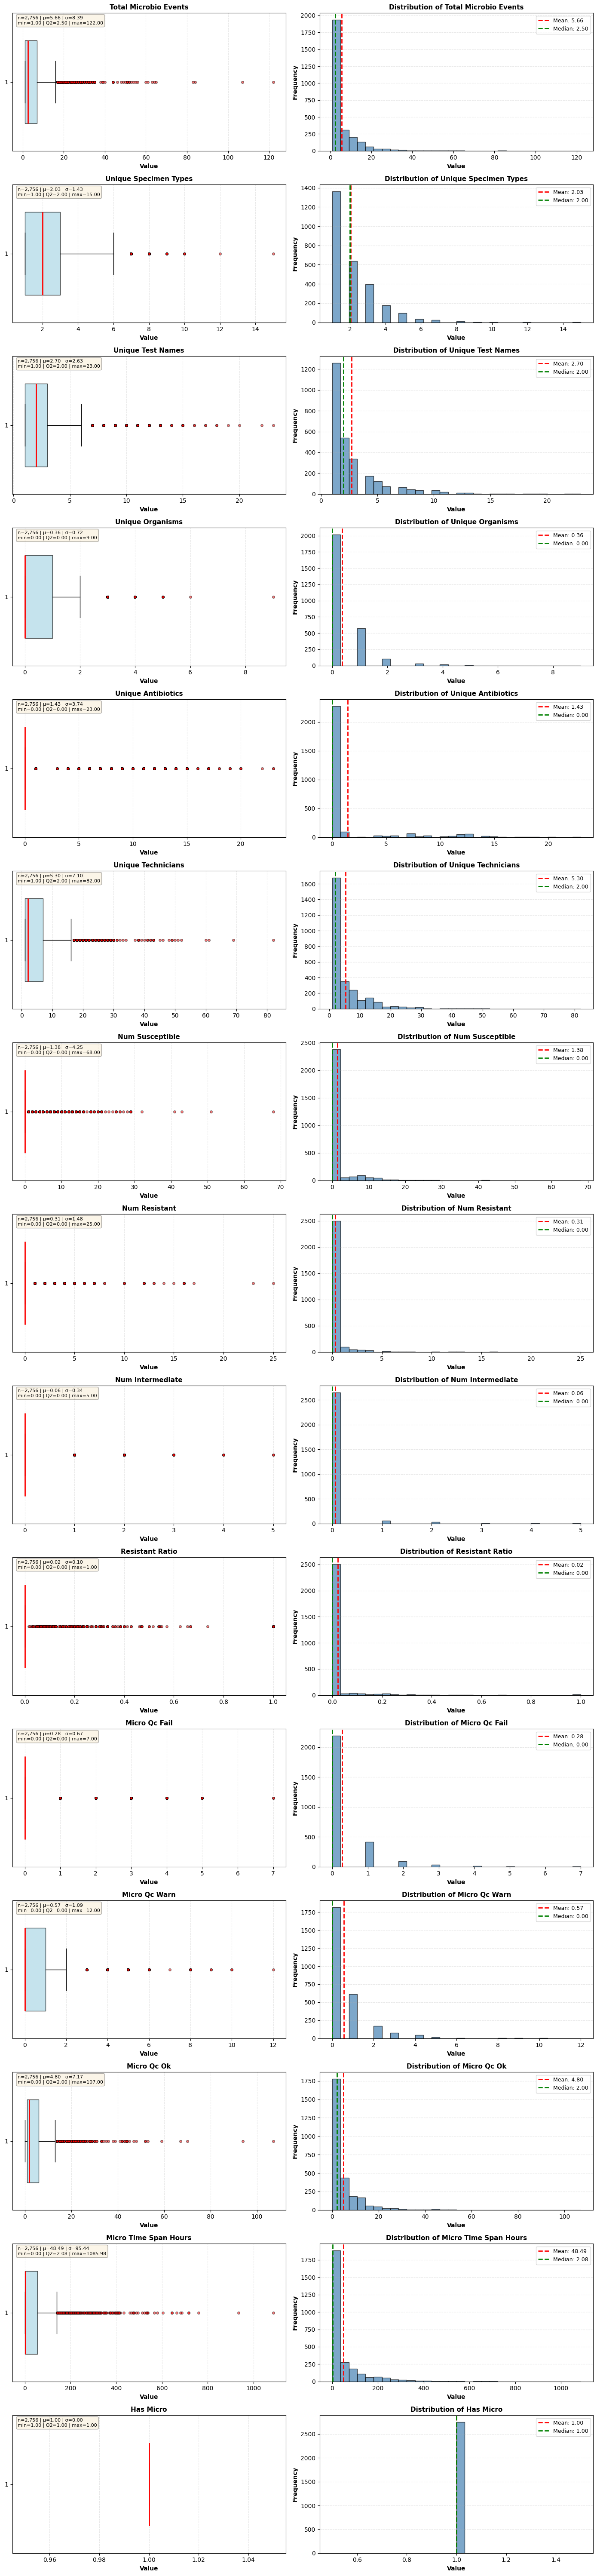


SUMMARY STATISTICS TABLE
              Feature  Count  Mean   Std  Min   Q1 Median    Q3     Max Skew
total_microbio_events   2756  5.66  8.39 1.00 1.00   2.50  7.00  122.00 4.49
unique_specimen_types   2756  2.03  1.43 1.00 1.00   2.00  3.00   15.00 2.08
    unique_test_names   2756  2.70  2.63 1.00 1.00   2.00  3.00   23.00 2.49
     unique_organisms   2756  0.36  0.72 0.00 0.00   0.00  1.00    9.00 3.13
   unique_antibiotics   2756  1.43  3.74 0.00 0.00   0.00  0.00   23.00 2.71
   unique_technicians   2756  5.30  7.10 1.00 1.00   2.00  7.00   82.00 3.30
      num_susceptible   2756  1.38  4.25 0.00 0.00   0.00  0.00   68.00 5.17
        num_resistant   2756  0.31  1.48 0.00 0.00   0.00  0.00   25.00 8.32
     num_intermediate   2756  0.06  0.34 0.00 0.00   0.00  0.00    5.00 7.79
      resistant_ratio   2756  0.02  0.10 0.00 0.00   0.00  0.00    1.00 6.66
        micro_qc_fail   2756  0.28  0.67 0.00 0.00   0.00  0.00    7.00 3.44
        micro_qc_warn   2756  0.57  1.09 0.00 0.00

In [136]:
# Boxplots + Histograms for all numeric features
print("="*80)
print("BOXPLOTS & HISTOGRAMS FOR NUMERIC FEATURES")
print("="*80)

# Get numeric columns (exclude IDs)
numeric_cols = micro_features.select_dtypes(include=[np.number]).columns.tolist()
id_cols = ['subject_id', 'hadm_id']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

print(f"\nAnalyzing {len(numeric_cols)} numeric features:\n{numeric_cols}\n")

# Create grid layout
n_cols = len(numeric_cols)
n_rows = n_cols
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows))

# Ensure axes is 2D array
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(numeric_cols):
    data = micro_features[col].dropna()
    
    # Statistics
    stats_text = f"n={len(data):,} | μ={data.mean():.2f} | σ={data.std():.2f}\nmin={data.min():.2f} | Q2={data.median():.2f} | max={data.max():.2f}"
    
    # Boxplot (left)
    ax_box = axes[idx, 0]
    bp = ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.6,
                         boxprops=dict(facecolor='lightblue', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2),
                         flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
    ax_box.set_xlabel('Value', fontsize=10, fontweight='bold')
    ax_box.set_title(f'{col.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax_box.grid(axis='x', alpha=0.3, linestyle='--')
    ax_box.text(0.02, 0.98, stats_text, transform=ax_box.transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Histogram (right)
    ax_hist = axes[idx, 1]
    n, bins, patches = ax_hist.hist(data, bins=30, edgecolor='black', 
                                     alpha=0.7, color='steelblue')
    ax_hist.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    ax_hist.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    ax_hist.set_xlabel('Value', fontsize=10, fontweight='bold')
    ax_hist.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax_hist.set_title(f'Distribution of {col.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax_hist.legend(fontsize=9)
    ax_hist.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('micro_features_boxplots_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("SUMMARY STATISTICS TABLE")
print("="*80)

# Create summary table
summary_stats = []
for col in numeric_cols:
    data = micro_features[col].dropna()
    summary_stats.append({
        'Feature': col,
        'Count': len(data),
        'Mean': f"{data.mean():.2f}",
        'Std': f"{data.std():.2f}",
        'Min': f"{data.min():.2f}",
        'Q1': f"{data.quantile(0.25):.2f}",
        'Median': f"{data.median():.2f}",
        'Q3': f"{data.quantile(0.75):.2f}",
        'Max': f"{data.max():.2f}",
        'Skew': f"{data.skew():.2f}"
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))


### Dropunused

In [137]:
micro_features.columns

Index(['subject_id', 'hadm_id', 'total_microbio_events',
       'unique_specimen_types', 'unique_test_names', 'unique_organisms',
       'unique_antibiotics', 'unique_technicians', 'num_susceptible',
       'num_resistant', 'num_intermediate', 'resistant_ratio', 'micro_qc_fail',
       'micro_qc_warn', 'micro_qc_ok', 'micro_time_span_hours', 'has_micro'],
      dtype='object')

In [ ]:
micro_features_small6 = [
    'subject_id',
    'hadm_id',
    'has_micro',
    'total_microbio_events',   # overall microbiology activity (dominant signal)
    'unique_specimen_types',   # sampling diversity
    'unique_organisms',        # biological diversity
    'resistant_ratio',         # susceptibility profile summary
    'unique_antibiotics',      # captures treatment relevance independent of organisms
    'num_susceptible',
   # 'unique_test_names'        # captures test diversity (operational dimension)
]
features_to_keep = [col for col in micro_features_small6 if col in micro_features.columns]
feat_reduced = micro_features[features_to_keep].copy()

### Corr

CORRELATION MATRIX ANALYSIS

Numeric columns found: ['subject_id', 'hadm_id', 'has_micro', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'unique_antibiotics']
Total numeric columns: 8

CORRELATION MATRIX
                       subject_id  hadm_id  has_micro  total_microbio_events  \
subject_id                  1.000   -0.011        NaN                 -0.086   
hadm_id                    -0.011    1.000        NaN                 -0.001   
has_micro                     NaN      NaN        NaN                    NaN   
total_microbio_events      -0.086   -0.001        NaN                  1.000   
unique_specimen_types      -0.112   -0.003        NaN                  0.665   
unique_organisms           -0.010   -0.028        NaN                  0.665   
resistant_ratio             0.045    0.003        NaN                  0.227   
unique_antibiotics         -0.052   -0.007        NaN                  0.643   

                       unique_sp

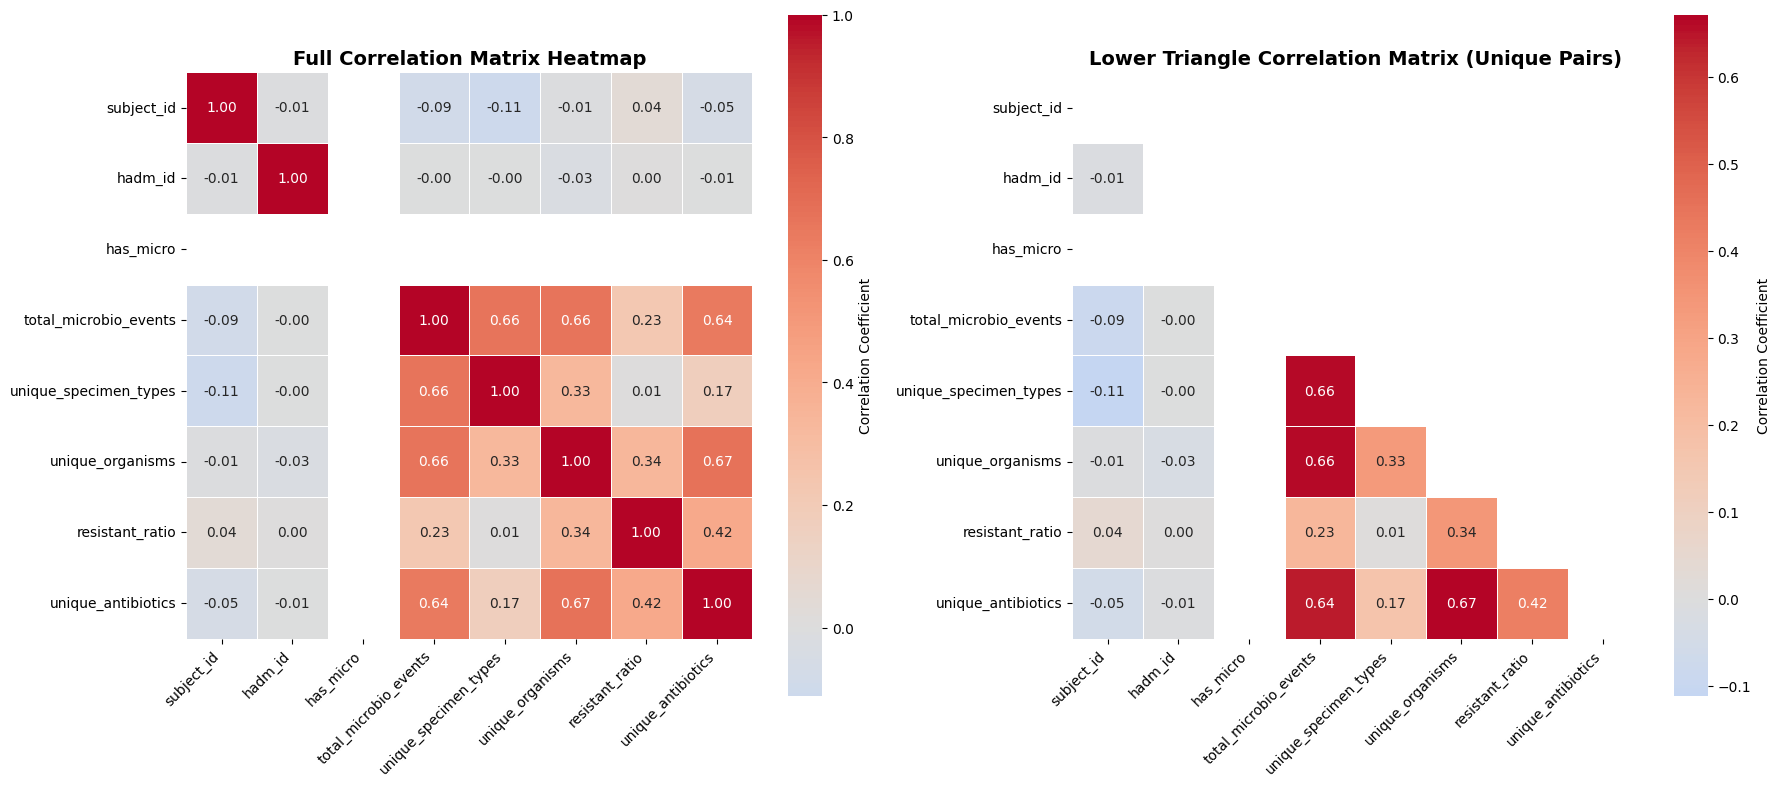


STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)

Found 4 strong correlations:

           Variable 1            Variable 2  Correlation        Strength
     unique_organisms    unique_antibiotics     0.671795 Strong Positive
total_microbio_events      unique_organisms     0.664818 Strong Positive
total_microbio_events unique_specimen_types     0.664577 Strong Positive
total_microbio_events    unique_antibiotics     0.642526 Strong Positive

MODERATE CORRELATIONS (0.3 < |r| ≤ 0.5)

Found 3 moderate correlations:

           Variable 1         Variable 2  Correlation          Strength
      resistant_ratio unique_antibiotics     0.419353 Moderate Positive
     unique_organisms    resistant_ratio     0.342308 Moderate Positive
unique_specimen_types   unique_organisms     0.330739 Moderate Positive

SUMMARY STATISTICS

Mean correlation: nan
Median correlation: nan
Std Dev: nan
Min: nan
Max: nan


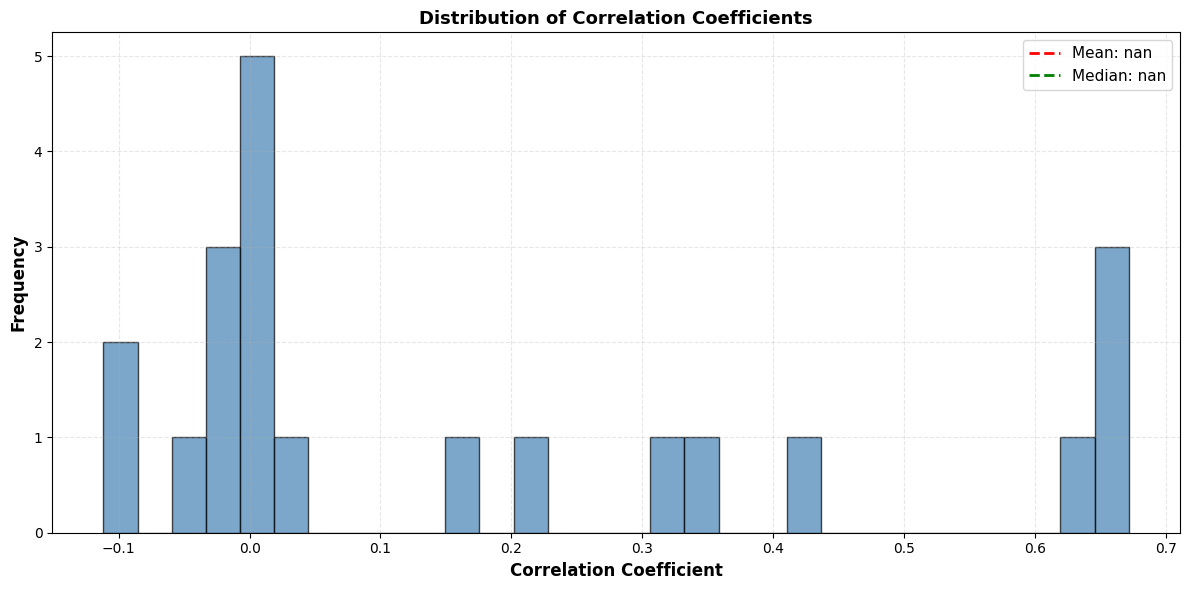

In [142]:
print("="*80)
print("CORRELATION MATRIX ANALYSIS")
print("="*80)

# Select numeric columns only
numeric_cols = feat_reduced.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns found: {numeric_cols}")
print(f"Total numeric columns: {len(numeric_cols)}\n")  

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    correlation_matrix = feat_reduced[numeric_cols].corr()
    
    print("="*80)
    print("CORRELATION MATRIX")
    print("="*80)
    print(correlation_matrix.round(3))
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Full correlation heatmap
    ax1 = axes[0]
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax1)
    ax1.set_title('Full Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Plot 2: Mask for upper triangle (cleaner view)
    ax2 = axes[1]
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                mask=mask,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax2)
    ax2.set_title('Lower Triangle Correlation Matrix (Unique Pairs)', fontsize=14, fontweight='bold')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extract strong correlations (> 0.5 or < -0.5, excluding diagonal)
    print("\n" + "="*80)
    print("STRONG CORRELATIONS (|r| > 0.5, excluding self-correlations)")
    print("="*80)
    
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.5:
                strong_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Strong Positive' if corr_value > 0 else 'Strong Negative'
                })
    
    if strong_corr:
        strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(strong_corr)} strong correlations:\n")
        print(strong_corr_df.to_string(index=False))
    else:
        print("\nNo correlations with |r| > 0.5 found")
    
    # Moderate correlations (0.3 to 0.5)
    print("\n" + "="*80)
    print("MODERATE CORRELATIONS (0.3 < |r| ≤ 0.5)")
    print("="*80)
    
    moderate_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if 0.3 < abs(corr_value) <= 0.5:
                moderate_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Moderate Positive' if corr_value > 0 else 'Moderate Negative'
                })
    
    if moderate_corr:
        moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlation', key=abs, ascending=False)
        print(f"\nFound {len(moderate_corr)} moderate correlations:\n")
        print(moderate_corr_df.to_string(index=False))
    else:
        print("\nNo moderate correlations found (0.3 < |r| ≤ 0.5)")
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Get correlation values (excluding diagonal)
    corr_values = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_values.append(correlation_matrix.iloc[i, j])
    
    corr_values = np.array(corr_values)
    print(f"\nMean correlation: {corr_values.mean():.3f}")
    print(f"Median correlation: {np.median(corr_values):.3f}")
    print(f"Std Dev: {corr_values.std():.3f}")
    print(f"Min: {corr_values.min():.3f}")
    print(f"Max: {corr_values.max():.3f}")
    
    # Distribution of correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(corr_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(corr_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {corr_values.mean():.3f}')
    ax.axvline(np.median(corr_values), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(corr_values):.3f}')
    ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Correlation Coefficients', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('correlation_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Not enough numeric columns for correlation analysis")
    print(f"Found only {len(numeric_cols)} numeric column(s)")

## Save SLim

In [143]:
feat_reduced.to_csv(f"{DATA_DIR}/{DATASETS[name].replace('.csv', '_agg_features.csv')}", index=False)